In [1]:
# !conda create -n hack4retail python=3.8 numpy pandas 
# scikit-learn lightgbm catboost plotly nb_conda ipykernel pyarrow gensim
import pandas as pd
import numpy as np
import plotly.express as px
import pandas_profiling as pp
from os.path import join as pjoin
from os import cpu_count
import sys
import os
import pandas as pd
import numpy as np
import json
import lightgbm as lgb
from pathlib import Path
import plotly.express as px

add_path = pjoin(os.getcwd(), '..')
add_path = Path(add_path).resolve()
sys.path.insert(0, str(add_path))

from competition_scripts.competition_utils import (
    add_features_to_skeleton, calculate_scores, 
    join_datasets, perc_mae_lgb, percentage_mae
)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Data description

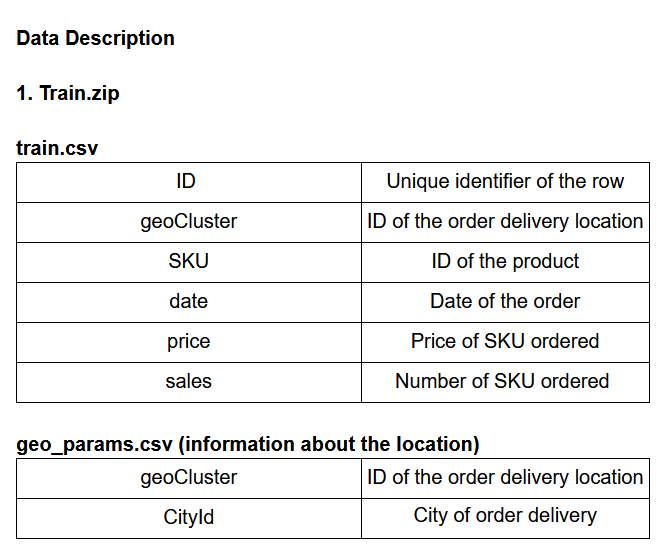

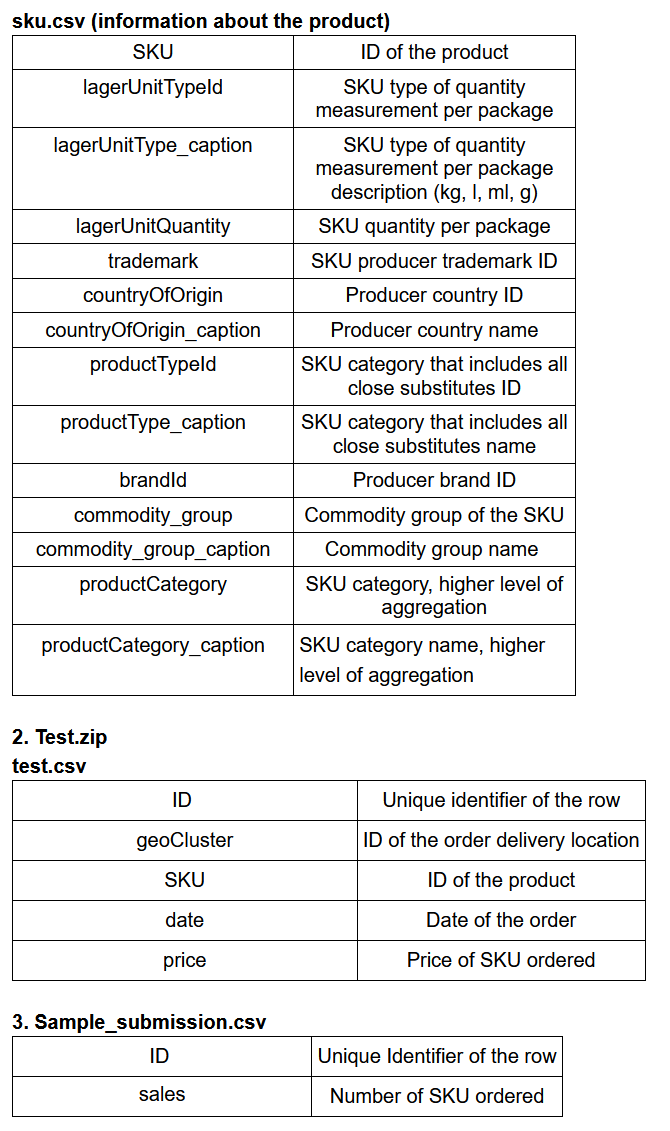

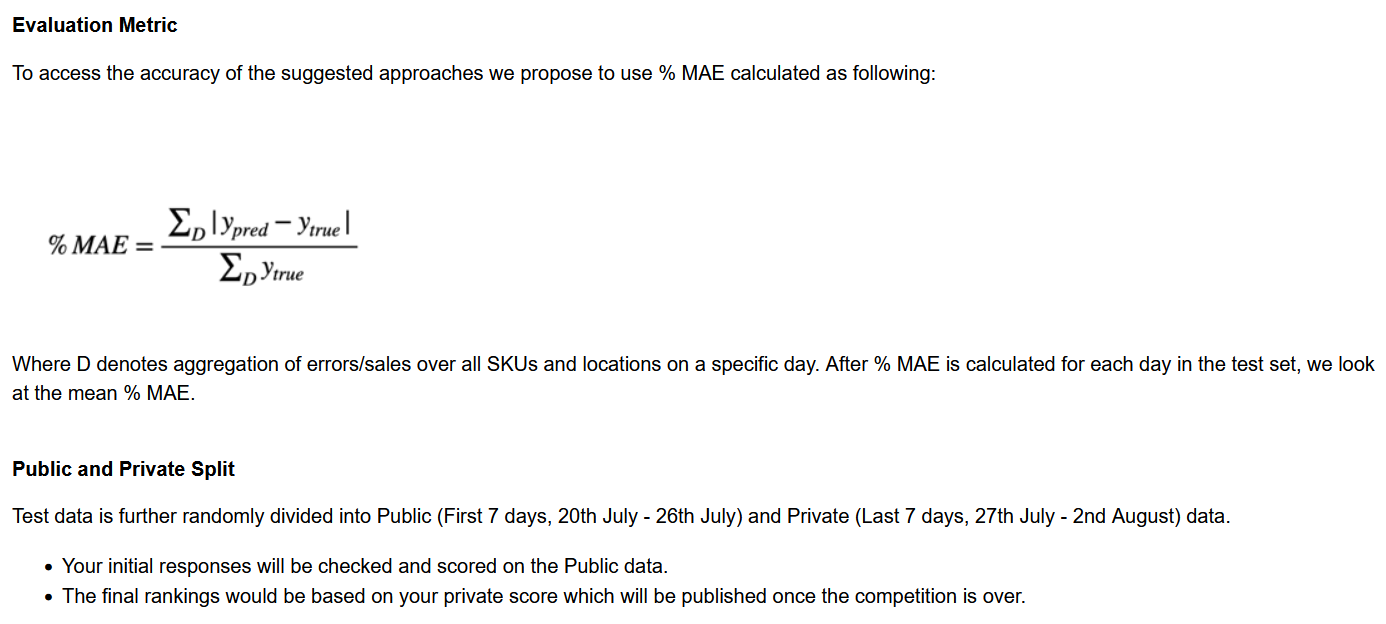

## Data load

In [2]:
DATA_DIR_RAW = pjoin('..', 'data', 'raw')
DATA_DIR_PROCESSED = pjoin('..', 'data', 'processed')
SUBMISSION_DIR = pjoin('..', 'submissions')

### Map column names (init) to human-readable ones (transformed)

In [3]:
# human readble to init column mapping

# geo-cols
col_mapping = {
    'geoCluster': 'geo_cluster_id',
    'cityId': 'city_id'
}

# sku cols
col_mapping.update(
    {
        'SKU': 'sku_id', 
        'productCategoryId': 'category_id',
        'productCategory_caption_UKR': 'title_ua',
       'productCategory_caption_RU': 'title_ru',
        'productCategory_caption_ENG': 'title_en',
       'productTypeId': 'product_type_id',
        'productType_caption_UKR': 'product_type_title_ua', 
        'productType_caption_RU': 'product_type_title_ru', 
       'productType_caption_ENG': 'product_type_title_en',  
        'brandId': 'brand_id', 
        'lagerUnitQuantity': 'quantity',
       'lagerUnitTypeId': 'measurement_type_id', 
        'lagerUnitType_caption': 'measurement_type',
        'trademark': 'trademark_id',
       'countryOfOrigin': 'origin_country_id',
        'countryOfOrigin_caption': 'origin_country', 
        'commodity_group': 'commodity_group_id',
       'commodity_group_caption_UKR': 'commodity_group_title_ua', 
        'commodity_group_caption_RU': 'commodity_group_title_ru', 
       'commodity_group_caption_ENG': 'commodity_group_title_en', 
    }
)

# train cols
col_mapping.update(
    {
        'ID': 'transaction_id', 
        'geoCluster': 'geo_cluster_id', 
        'SKU': 'sku_id', 
        'date': 'date', 
        'price': 'price', 
        'sales': 'sales'
    }
)

# test cols
col_mapping.update(
    {
        'ID': 'transaction_id',
        'geoCluster': 'geo_cluster_id',
        'SKU': 'sku_id',
        'date': 'date',
        'price': 'price'
        
    }
)
    
col_mapping_inv = {
    v:k for k,v in col_mapping.items()
}

col_mapping

{'geoCluster': 'geo_cluster_id',
 'cityId': 'city_id',
 'SKU': 'sku_id',
 'productCategoryId': 'category_id',
 'productCategory_caption_UKR': 'title_ua',
 'productCategory_caption_RU': 'title_ru',
 'productCategory_caption_ENG': 'title_en',
 'productTypeId': 'product_type_id',
 'productType_caption_UKR': 'product_type_title_ua',
 'productType_caption_RU': 'product_type_title_ru',
 'productType_caption_ENG': 'product_type_title_en',
 'brandId': 'brand_id',
 'lagerUnitQuantity': 'quantity',
 'lagerUnitTypeId': 'measurement_type_id',
 'lagerUnitType_caption': 'measurement_type',
 'trademark': 'trademark_id',
 'countryOfOrigin': 'origin_country_id',
 'countryOfOrigin_caption': 'origin_country',
 'commodity_group': 'commodity_group_id',
 'commodity_group_caption_UKR': 'commodity_group_title_ua',
 'commodity_group_caption_RU': 'commodity_group_title_ru',
 'commodity_group_caption_ENG': 'commodity_group_title_en',
 'ID': 'transaction_id',
 'date': 'date',
 'price': 'price',
 'sales': 'sales'}

### Geo-mapping

In [4]:
# geo-data
df_geo = pd.read_csv(pjoin(DATA_DIR_RAW, 'geo_params.csv'))

print(df_geo.shape)
df_geo = df_geo.astype(np.int16)
df_geo = df_geo.rename(columns={c: col_mapping[c] for c in df_geo.columns})
df_geo = df_geo.set_index('geo_cluster_id')
df_geo.head()

(515, 2)


,city_id
geo_cluster_id,
21,1
47,1
48,1
92,1
112,1


### SKU data

In [5]:
df_sku = pd.read_csv(pjoin(DATA_DIR_RAW, 'sku_final.csv'))
print(df_sku.shape)

df_sku = df_sku.rename(
    columns={c: col_mapping[c] for c in df_sku.columns}
)

df_sku['sku_id'] = df_sku['sku_id'].astype(np.int32)
df_sku = df_sku.set_index('sku_id')

df_sku['category_id'] = df_sku['category_id'].astype(np.int32)

# drop non-english titles
cols_to_drop = df_sku.filter(regex='.*(_ua|_ru)$').columns.tolist()
df_sku = df_sku[[c for c in df_sku.columns if c not in cols_to_drop]]

# process outliers/typos
# outliers in ids = -1
outlier_id = -1 
outlier_title = '<UNK>'

df_sku['measurement_type'] = df_sku['measurement_type']\
.str.replace('\s+', '', regex=True)
df_sku['product_type_id'] = df_sku['product_type_id'].fillna(outlier_id).astype(np.int32)
df_sku['brand_id'] = df_sku['brand_id'].fillna(outlier_id).astype(np.int32)
df_sku['trademark_id'] = df_sku['trademark_id'].fillna(outlier_id).astype(np.int32)
df_sku['origin_country'] = \
df_sku['origin_country'].fillna(outlier_title).astype(str)
df_sku['origin_country_id'] = \
df_sku['origin_country_id'].fillna(outlier_id).astype(np.int32)

df_sku['commodity_group_title_en'] = \
df_sku['commodity_group_title_en'].fillna(outlier_title).astype(str)
df_sku['commodity_group_id'] = \
df_sku['commodity_group_id'].fillna(outlier_id).astype(np.int32)

df_sku['measurement_type_id'] = df_sku['measurement_type_id'].astype(np.int8)
df_sku['quantity'] = df_sku['quantity'].astype(np.float32)

# TODO: optimize types
print(df_sku.isnull().mean())

df_sku.head()

(1961, 20)
category_id                 0.000000
title_en                    0.078531
product_type_id             0.000000
product_type_title_en       0.202958
brand_id                    0.000000
quantity                    0.000000
measurement_type_id         0.000000
measurement_type            0.000000
trademark_id                0.000000
origin_country_id           0.000000
origin_country              0.000000
commodity_group_id          0.000000
commodity_group_title_en    0.000000
dtype: float64


,category_id,title_en,product_type_id,product_type_title_en,brand_id,quantity,measurement_type_id,measurement_type,trademark_id,origin_country_id,origin_country,commodity_group_id,commodity_group_title_en
sku_id,,,,,,,,,,,,,
17,5416,Persimmon,4770,Tropical fruit — Persimmon — Plain,-1,1.0,1,г,-1,-1,<UNK>,5551018,Tropical fruits
18,5413,Feijoa,4772,Tropical fruit — Exotic,-1,1.0,1,г,-1,-1,<UNK>,5551018,Tropical fruits
24,5425,Pomegranate,4760,Tropical fruit — Pomegranate— Plain,-1,1.0,1,г,-1,-1,<UNK>,5551018,Tropical fruits
25,5431,Orange,4773,Citrus fruit — Orange — Plain,-1,1.0,2,кг,-1,8,Іспанія,5551018,Tropical fruits
208,5835,"Water, Ukraine, sparkling",3457,Therapeutic-table water — Ukraine — PET — from...,1241,1.5,3,л,3670,1,Україна,5550022,Mineral water


### train data (skeleton)

In [6]:
df_train = pd.read_csv(pjoin(DATA_DIR_RAW, 'train_final.csv'))
print(df_train.shape)

df_train = df_train.rename(
    columns={c: col_mapping[c] for c in df_train.columns}
)

# optimize types
df_train.transaction_id = df_train.transaction_id.str.replace(
    'RR', '', regex=False).astype(np.int32)
df_train['sku_id'] = df_train['sku_id'].astype(np.int32)
df_train.geo_cluster_id = df_train.geo_cluster_id.astype(np.int16)
df_train['price'] = df_train['price'].astype(np.float32)
df_train['sales'] = df_train['sales'].astype(np.float32)

# convert dates
uniq_dates_str = df_train['date'].unique()
uniq_dates_date = pd.to_datetime(uniq_dates_str)
date_mapping = dict(zip(uniq_dates_str, uniq_dates_date.values))

df_train['date'] = df_train['date'].map(date_mapping)
df_train = df_train.set_index('transaction_id')

# fillna 0 where sales = 0
df_train['sales'] = df_train['sales'].fillna(0)

df_train.head()

(27956445, 6)


,geo_cluster_id,sku_id,date,price,sales
transaction_id,,,,,
27956447,21,32485,2021-07-08,39.689999,0.9
27956448,21,32485,2021-07-09,NaN,0.0
27956449,21,32485,2021-07-10,NaN,0.0
27956450,21,32485,2021-07-11,NaN,0.0
27956451,21,32485,2021-07-12,NaN,0.0


In [7]:
# assume it's properly sorted
df_train.sort_values(by=['sku_id', 'geo_cluster_id', 'date'], inplace=True)

In [8]:
# try fillna in prices within sku, cluster grouping
# forward then backward, takes time, have to wait for 1-2 min
price_keys = ['sku_id', 'geo_cluster_id']
df_train['price'] = df_train.groupby(price_keys)['price'].fillna(method='ffill').values
df_train['price'] = df_train.groupby(price_keys)['price'].fillna(method='bfill').values

In [9]:
# can be safely used for now
print(df_train['price'].isnull().mean())
df_train[['price', 'sales']].corr()

0.0018423658659031934


,price,sales
price,1.000000,-0.057654
sales,-0.057654,1.000000


In [10]:
# test data
df_test = pd.read_csv(pjoin(DATA_DIR_RAW, 'test_data.csv'))
df_test = df_test.rename(
    columns={c: col_mapping[c] for c in df_test.columns}
)
print(df_test.shape)
assert df_test.isnull().sum().sum() == 0

# optimize types
df_test.transaction_id = df_test.transaction_id.str.replace(
    'RR', '', regex=False).astype(np.int32)
df_test['sku_id'] = df_test['sku_id'].astype(np.int32)
df_test.geo_cluster_id = df_test.geo_cluster_id.astype(np.int16)
df_test['price'] = df_test['price'].astype(np.float32)
df_test['sales'] = np.nan
df_test['sales'] = df_test['sales'].astype(np.float32)
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.set_index('transaction_id')

print(df_test.dtypes)

df_test.head()

(1666028, 5)
geo_cluster_id             int16
sku_id                     int32
date              datetime64[ns]
price                    float32
sales                    float32
dtype: object


,geo_cluster_id,sku_id,date,price,sales
transaction_id,,,,,
1666030,21,32485,2021-07-20,66.690002,NaN
1666031,21,32485,2021-07-21,66.690002,NaN
1666032,21,32485,2021-07-22,66.690002,NaN
1666033,21,32485,2021-07-23,66.690002,NaN
1666034,21,32485,2021-07-24,66.690002,NaN


### Basic feature engineering

In [11]:
group_cols = ('sku_id', 'geo_cluster_id')
date_col = 'date'
target_col = 'sales'

dfs_to_join = {
    'df_geo': df_geo,
    'df_sku': df_sku,
}

# make 1 joint dataset for correct calculations, then split by transaction_id

# join datasets
df_train = join_datasets(
    df_train,
    other_dfs=dfs_to_join,
)

df_test = join_datasets(
    df_test,
    other_dfs=dfs_to_join,
)

df_joint = pd.concat(
    [df_train, df_test],
    axis=0,
)

df_joint = df_joint.sort_values(by=['sku_id', 'geo_cluster_id', 'date'])

# # calculate features
# df_train = add_features_to_skeleton(
#     df=df_train,
#     date_col=date_col,
#     target_col=target_col,
#     group_cols=group_cols,
# )

# # calculate features
# df_test = add_features_to_skeleton(
#     df=df_test,
#     date_col=date_col,
#     target_col=target_col,
#     group_cols=group_cols,
# )

joining datasets...
joining datasets...


In [12]:
def add_features_to_skeleton(
    df: pd.DataFrame, 
    date_col: str = 'date',
    target_col: str = 'sales',
    group_cols : tuple = ('sku_id', 'geo_cluster_id'),
) -> pd.DataFrame:
    print('calculating temporal features...')
    df['weekday'] = df['date'].dt.weekday.astype(np.int8)
    df['week_no'] = df['date'].dt.isocalendar().week.astype(np.int8)
    df['month'] = df['date'].dt.month.astype(np.int8)
    print('calculating price features')
    df['price_change_perc'] = (
        df['price'] / df.groupby(list(group_cols))['price'].shift() - 1
    ).replace([np.inf, -np.inf, np.nan], 0.).astype(np.float32)
    df['price_change_logdiff'] = np.log(
        df['price'] / df.groupby(list(group_cols))['price'].shift()
    ).replace([np.inf, -np.inf, np.nan], 0.).astype(np.float32)
    return df

In [13]:
df_joint = add_features_to_skeleton(
    df=df_joint,
    date_col=date_col,
    target_col=target_col,
    group_cols=group_cols,
)

calculating temporal features...
calculating price features


C:\Users\Neoclassic\anaconda3\envs\hack4retail\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
df_joint.isnull().mean()

geo_cluster_id          0.000000
sku_id                  0.000000
date                    0.000000
price                   0.001739
sales                   0.056242
city_id                 0.000000
category_id             0.000000
product_type_id         0.000000
brand_id                0.000000
trademark_id            0.000000
origin_country_id       0.000000
commodity_group_id      0.000000
weekday                 0.000000
week_no                 0.000000
month                   0.000000
price_change_perc       0.000000
price_change_logdiff    0.000000
dtype: float64

In [15]:
assert set(df_train.columns) - set(df_test.columns) == set()

In [16]:
# split back train and test
df_train = df_joint.reindex(df_train.index)
df_test = df_joint.reindex(df_test.index)

### Saving processed files to processed dir

In [17]:
import json

# train
df_train.to_parquet(pjoin(DATA_DIR_PROCESSED, 'df_train.parquet'))
# test
df_test.to_parquet(pjoin(DATA_DIR_PROCESSED, 'df_test.parquet'))

# df_sku
df_sku.to_parquet(pjoin(DATA_DIR_PROCESSED, 'df_sku.parquet'))

# df_geo
df_sku.to_parquet(pjoin(DATA_DIR_PROCESSED, 'df_geo.parquet'))

# col_mapping
colmapping_dict = {
    'forward': col_mapping,
    'inverse': col_mapping_inv,
}

with open(pjoin(DATA_DIR_PROCESSED, 'col_mapping.json'), 'w') as f:
    json.dump(colmapping_dict, f)

### Baseline

### temporal train/val/test splits

In [22]:
val_period_pub_length = 7
val_period_pr_length = 7

train_period = [
    df_train[date_col].min(),
    df_train[date_col].max() - pd.Timedelta(
        days=val_period_pr_length + val_period_pub_length)
]
val_period_public = [
    df_train[date_col].max() - pd.Timedelta(
        days=val_period_pr_length + val_period_pub_length - 1),
    df_train[date_col].max() - pd.Timedelta(days=val_period_pr_length)
]
val_period_private = [
    df_train[date_col].max() - pd.Timedelta(days=val_period_pr_length - 1),
    df_train[date_col].max()
]

idx_train = (
    (df_train[date_col] >= train_period[0]) 
    & (df_train[date_col] <= train_period[1])
)

idx_train_last_month = (
    (df_train[date_col] >= train_period[1] - pd.Timedelta(days=28)) 
    & (df_train[date_col] <= train_period[1])
)

idx_val = (
    (df_train[date_col] >= val_period_public[0]) 
    & (df_train[date_col] <= val_period_public[1])
)
idx_test = (
    (df_train[date_col] >= val_period_private[0]) 
    & (df_train[date_col] <= val_period_private[1])
)

assert (idx_test | idx_train | idx_val).mean() == 1.

In [23]:
# check baseline
grouping = ['sku_id', 'geo_cluster_id']
baseline_dict = df_train[idx_train_last_month].groupby(grouping)[target_col].median()

pred_baseline_val = \
df_train[idx_val].set_index(grouping).index.map(baseline_dict).fillna(0).values
pred_baseline_test = \
df_train[idx_test].set_index(grouping).index.map(baseline_dict).fillna(0).values

In [24]:
print('median baseline')
baseline_score_pub, baseline_score_pr = calculate_scores(
    df=df_train,
    idx_val=idx_val,
    idx_test=idx_test,
    pred_val=pred_baseline_val,
    pred_test=pred_baseline_test,
    grouping_col=date_col,
    target_col=target_col
)

median baseline
public : 0.93600
private: 0.93877



In [26]:
# load sample submission
subm = pd.read_csv(pjoin(DATA_DIR_RAW, 'sample_final.csv'))
subm['sales'] = subm_pred
subm['sales'] = subm['sales'].fillna(0.)

score_pub = str(round(baseline_score_pub, 5)).replace('.', '_')
score_pr = str(round(baseline_score_pr, 5)).replace('.', '_')
subm_name = f'baseline_validation_pub={score_pub}_pr={score_pr}.csv'
# subm.to_csv(
#     pjoin(SUBMISSION_DIR, subm_name),
#     index=False
# )

print(subm_name)

baseline_validation_pub=0_936_pr=0_93877.csv
